### 1. 介绍 Introduction
-------------

AlexNet是由Alex Krizhevsky, Ilya Sutskever, Geoffrey E Hinton发表，并赢得ImageNet 2012挑战赛。

论文地址：
[AlexNet](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

源代码：
[AlexNet源代码](https://github.com/dansuh17/alexnet-pytorch/blob/d0c1b1c52296ffcbecfbf5b17e1d1685b4ca6744/model.py#L40)

In [1]:
from IPython.display import Image, display
url = 'https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_6.35.45_PM.png'
display(Image(url=url, width=600))

### 2. torchvision中AlexNet对比
------------

由于torchvision中有AlexNet模版，先输出研究下：

torchvision中的AlexNet与论文版本有差异：
- 前两个卷积层有变化变化。torchvision：64→192→384→256→256；原版本：96→256→384→256→256
- 原版本每个激活层后有 LocalResponseNorm， torchvision中没有
- torch版本有一层AdaptiveAvgPool2d

In [7]:
import torchvision.models as models

AlexNet = models.AlexNet()
print(AlexNet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### 3. 修改实现
----------------

目标：保持AlexNet整体框架不变，在CIFAR10数据集上进行训练
- 将CIFAR10数据Resize到224×224，只能当作练习用
- 所有参数裁半
- LocalResponseNorm层用BatchNorm替代

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import datasets

In [53]:
batch_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10
lr = 1e-3
epochs = 5

In [35]:
# 定义数据转换方法
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])
# 定义训练集
train_dataset = datasets.CIFAR10(root = './data',
                                          train = True,
                                          transform = transform,
                                          download = True)
# 定义测试集
test_dataset = datasets.CIFAR10(root = './data',
                                         train = False,
                                         transform = transform,
                                         download = True)

# 加载训练数据，并打乱
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# 加载测试数据
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


torch.Size([256, 3, 224, 224]) torch.Size([256]) tensor([0, 2, 0, 6, 6, 8, 6, 6, 0, 8, 4, 2, 5, 2, 5, 8, 3, 3, 4, 0, 7, 3, 0, 3,
        6, 5, 7, 6, 1, 8, 6, 1, 8, 8, 6, 5, 8, 3, 9, 3, 2, 9, 5, 6, 6, 4, 9, 5,
        5, 0, 0, 0, 5, 5, 2, 5, 3, 0, 6, 9, 9, 0, 8, 9, 9, 7, 9, 7, 7, 3, 7, 8,
        0, 3, 1, 5, 5, 1, 6, 5, 6, 5, 6, 3, 5, 0, 3, 5, 7, 0, 3, 8, 5, 6, 4, 3,
        3, 1, 7, 5, 4, 7, 7, 8, 9, 5, 4, 0, 4, 8, 5, 8, 7, 0, 9, 2, 6, 5, 9, 6,
        0, 1, 2, 7, 2, 6, 3, 2, 0, 2, 1, 9, 6, 5, 0, 7, 1, 3, 4, 6, 1, 2, 4, 0,
        8, 2, 3, 8, 9, 1, 8, 5, 6, 3, 9, 8, 3, 4, 5, 3, 1, 9, 1, 6, 8, 4, 3, 2,
        0, 7, 3, 7, 1, 1, 5, 4, 6, 5, 8, 7, 5, 6, 7, 9, 6, 3, 5, 5, 2, 6, 4, 1,
        4, 0, 3, 7, 9, 2, 2, 4, 7, 8, 4, 6, 4, 6, 7, 0, 9, 3, 2, 6, 7, 5, 3, 0,
        8, 2, 9, 6, 2, 5, 9, 6, 8, 4, 9, 6, 2, 8, 0, 0, 7, 1, 8, 9, 7, 7, 1, 5,
        2, 6, 3, 2, 8, 8, 3, 5, 3, 0, 7, 6, 6, 9, 6, 5])


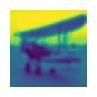

In [36]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape, label)
plt.figure(figsize=(1, 1))
plt.axis('off')
plt.imshow(image[0][0], cmap='viridis')

In [55]:
class AlexNet(nn.Module): # 定义类，继承自pytorch的nn.Module基类
    def __init__(self): # 初始化
        super(AlexNet, self).__init__() # 显示调用父类的构造方法
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=36, kernel_size=5, stride=4),  
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(36, 128, 5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(128 * 6 * 6), out_features=2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=num_classes),
        )

    def forward(self, x):
        x = self.net(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [56]:
model = AlexNet()
model = model.cuda()
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)

In [57]:
# 定义训练函数
def train(epoch):
    model.train()
    train_loss = 0
    correct_num = 0
    total_num = 0
    
    # 遍历训练数据
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda() # 将数据和标签挪到GPU        
        optimizer.zero_grad() # 梯度清理
        output = model(data) # 前向传播
        
        loss = criterion(output, label) # 计算损失，也就是预测结果和真实标签的误差
        loss.backward() # 反向传播，计算梯度
        optimizer.step() # 更新一步参数
        
        train_loss += loss.item() #计算损失
        preds = torch.argmax(output, dim=1)
        correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
        total_num += data.size(0) # 总预测数量
    train_loss = train_loss/len(train_loader.dataset) # 计算平均训练损失
    accuracy = correct_num/total_num # 计算准确率
    print(f'Epoch:{epoch}\tTraining Loss:{train_loss:.6f}, Accuracy:{accuracy:.6f}') # 输出信息

In [58]:
# 定义验证函数并初始化
def evaluate(epoch): 
    model.eval() # 验证模式
    evaluate_loss = 0 #累积验证损失
    correct_num = 0 
    total_num = 0 
    
    # 禁用梯度
    with torch.no_grad():
        # 遍历测试数据
        for data, label in test_loader: 
            data, label = data.cuda(), label.cuda() #数据迁移到GPU            
            output = model(data) # 前向传播
            
            loss = criterion(output, label) # 计算当前批次损失
            evaluate_loss += loss.item() # 累积总损失
            preds = torch.argmax(output, dim=1) # 取得每行最大值的索引，获取预测结果。
            correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
            total_num += data.size(0) # 总预测数量
    evaluate_loss = evaluate_loss/total_num # 计算平均验证损失
    accuracy = correct_num/total_num # 计算准确率
    print(f'Epoch:{epoch}\tValidation Loss:{evaluate_loss:.6f}, Accuracy:{accuracy:.6f}') #打印输出信息

In [52]:
for epoch in range(1, epochs+1):
    train(epoch)
    evaluate(epoch)

Epoch:1	Training Loss:0.773573, Accuracy:0.727040
Epoch:1	Validation Loss:1.088993, Accuracy:0.621900
Epoch:2	Training Loss:0.693566, Accuracy:0.759200
Epoch:2	Validation Loss:0.759285, Accuracy:0.744400
Epoch:3	Training Loss:0.627502, Accuracy:0.779620
Epoch:3	Validation Loss:0.714460, Accuracy:0.758300
Epoch:4	Training Loss:0.577621, Accuracy:0.798520
Epoch:4	Validation Loss:0.770314, Accuracy:0.729600
Epoch:5	Training Loss:0.535428, Accuracy:0.811000
Epoch:5	Validation Loss:0.656842, Accuracy:0.776100


### 4. 收获
-------------

LeNet带来了如下经验：
- 正如论文所言：“Our results show that a large, deep convolutional neural network is capable of achieving recordbreaking results on a highly challenging dataset using purely supervised learning.”
- 数据扩张：128万张图片，1000类
- 模型扩张：60M参数
- 防止过拟合：数据增强(data augmentation)+dropout
- 训练技术：GPU+分布式